In [1]:
import os
import tarfile

# import matplotlib as mpl
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint
from six.moves import urllib
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedShuffleSplit, train_test_split)
from sklearn.tree import DecisionTreeRegressor


In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=DOWNLOAD_ROOT):
    csv_path = housing_path + "datasets/housing/housing.csv"
    return pd.read_csv(csv_path)


housing = load_housing_data()

In [3]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

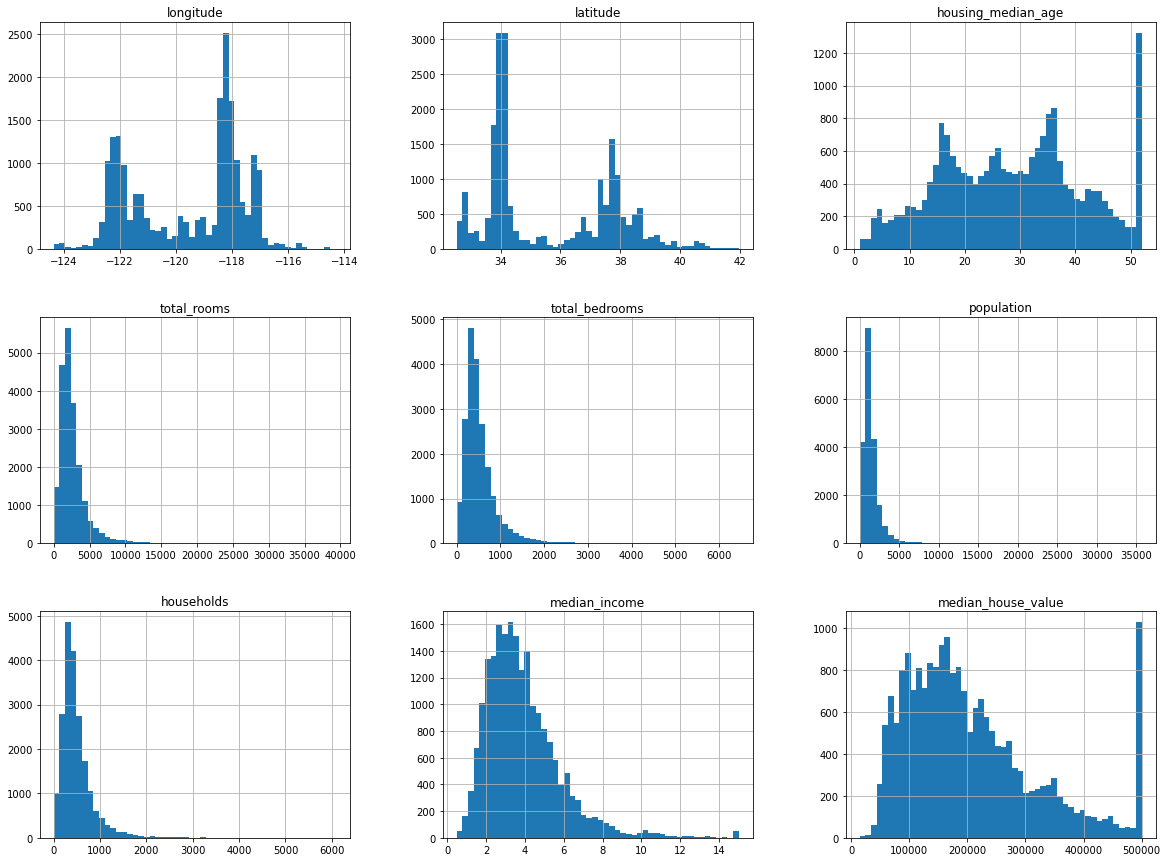

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

[12655 15502  2908 ... 19263 19140 19773] [ 5241 17352  3505 ... 17223 10786  3965]


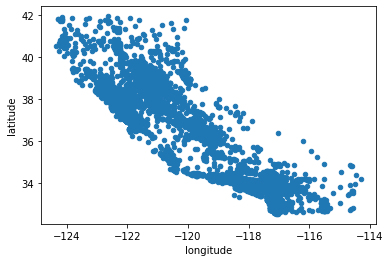

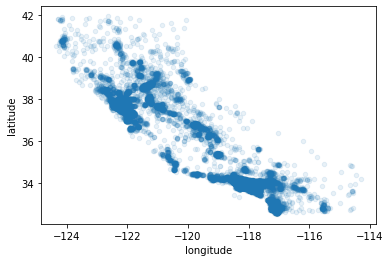

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    print(train_index, test_index)

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(strat_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()
compare_props["Rand. %error"] = (
    100 * compare_props["Random"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / \
    housing["total_rooms"]
housing["population_per_household"] = housing["population"] / \
    housing["households"]

imputer.fit(housing_num)
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr["rooms_per_household"] = housing_tr["total_rooms"] / \
    housing_tr["households"]
housing_tr["bedrooms_per_room"] = (
    housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
)
housing_tr["population_per_household"] = (
    housing_tr["population"] / housing_tr["households"]
)



In [8]:
#housing = strat_train_set.drop("median_house_value", axis=1)  
# # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
housing_cat = housing[["ocean_proximity"]]
'''housing_prepared = housing_tr.join(
    pd.get_dummies(housing_cat, drop_first=True))'''

'housing_prepared = housing_tr.join(\n    pd.get_dummies(housing_cat, drop_first=True))'

In [9]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [34]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [11]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [16]:
housing.values[:1]

array([[-121.46, 38.52, 29.0, 3873.0, 797.0, 2237.0, 706.0, 2.1736,
        72100.0, 'INLAND', 5.485835694050992, 0.20578363026077975,
        3.168555240793201]], dtype=object)

In [14]:
housing_extra_attribs[:1]

array([[-121.46, 38.52, 29.0, 3873.0, 797.0, 2237.0, 706.0, 2.1736,
        72100.0, 'INLAND', 5.485835694050992, 0.20578363026077975,
        3.168555240793201, 5.485835694050992, 3.168555240793201]],
      dtype=object)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [39]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [40]:
from sklearn.svm import SVR
svr_reg = SVR()
svr_reg.fit(housing_prepared, housing_labels)

SVR()

In [41]:
housing_labels[:8]

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
1481     165700.0
18125    412300.0
5830     349600.0
Name: median_house_value, dtype: float64

In [42]:
housing_predictions = svr_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118192.41887361684

In [43]:
svr_mae = mean_absolute_error(housing_labels, housing_predictions)
svr_mae

87722.79056076857

In [44]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("svr", SVR())])
pipe.fit(housing_prepared, housing_labels)

Pipeline(steps=[('svr', SVR())])

In [14]:
param_grid = {'svr__C': [ 0.01, 0.1, 1],
              'svr__gamma': [ 0.01, 0.1,1],
              'svr__kernel': ['rbf','linear']}
grid = RandomizedSearchCV(pipe, param_distributions=param_grid,scoring='neg_mean_squared_error',cv=5)
grid.fit(housing_prepared, housing_labels)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(housing_prepared, housing_labels)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: -9129808811.10
Test set score: -8667706178.57
Best parameters: {'svr__kernel': 'linear', 'svr__gamma': 1, 'svr__C': 1}


In [14]:
from sklearn.pipeline import make_pipeline
pipe2 = make_pipeline((SVR()))
pipe2.fit(housing_prepared, housing_labels)

Pipeline(memory=None,
         steps=[('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [15]:
param_grid = {'svr__C': [ 0.01, 0.1, 1],
              'svr__gamma': [ 0.01, 0.1, 1],
              'svr__kernel': ['rbf','linear']}
grid = RandomizedSearchCV(pipe, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5)
grid.fit(housing_prepared, housing_labels)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(housing_prepared, housing_labels)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: -9129808811.10
Test set score: -8667706178.57
Best parameters: {'svr__kernel': 'linear', 'svr__gamma': 0.1, 'svr__C': 1}


In [20]:
cvres = grid.cv_results_
for mean_score, params, rank in zip(cvres["mean_test_score"], cvres["params"], cvres['rank_test_score']):
    print(np.sqrt(-mean_score), params , rank)

95550.03302509003 {'svr__kernel': 'linear', 'svr__gamma': 0.1, 'svr__C': 1} 1
118923.16798292597 {'svr__kernel': 'rbf', 'svr__gamma': 0.1, 'svr__C': 0.1} 8
118923.16775874721 {'svr__kernel': 'rbf', 'svr__gamma': 0.01, 'svr__C': 0.1} 7
118923.18671198525 {'svr__kernel': 'rbf', 'svr__gamma': 0.01, 'svr__C': 1} 9
95550.03302509003 {'svr__kernel': 'linear', 'svr__gamma': 0.01, 'svr__C': 1} 1
95550.03302509003 {'svr__kernel': 'linear', 'svr__gamma': 1, 'svr__C': 1} 1
118923.18895218647 {'svr__kernel': 'rbf', 'svr__gamma': 1, 'svr__C': 1} 10
106561.16515140585 {'svr__kernel': 'linear', 'svr__gamma': 0.01, 'svr__C': 0.1} 4
109288.51156699542 {'svr__kernel': 'linear', 'svr__gamma': 1, 'svr__C': 0.01} 5
109288.51156699542 {'svr__kernel': 'linear', 'svr__gamma': 0.01, 'svr__C': 0.01} 5


 One way of exract the feature importance. 

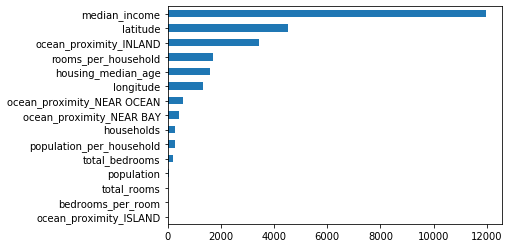

In [ ]:
pd.Series(abs(SVR(kernel='linear',C=1,gamma=1).fit(housing_prepared, housing_labels).coef_[0])
,index = housing_prepared.columns).sort_values(ascending=True).plot(kind='barh')

In [ ]:
pd.Series(abs(SVR(kernel='linear',C=1,gamma=1).fit(housing_prepared, housing_labels).coef_[0])
,index = housing_prepared.columns)

longitude                      1348.955415
latitude                       4540.032085
housing_median_age             1601.883426
total_rooms                      26.199602
total_bedrooms                  195.604651
population                       60.073839
households                      280.796935
median_income                 11984.042280
rooms_per_household            1692.166577
bedrooms_per_room                13.590020
population_per_household        262.714699
ocean_proximity_INLAND         3426.437460
ocean_proximity_ISLAND            2.000000
ocean_proximity_NEAR BAY        432.119454
ocean_proximity_NEAR OCEAN      574.000000
dtype: float64

Another way extract the feature importance

In [ ]:
print("SVR coefficients:\n{}".format(
      grid.best_estimator_.named_steps["svr"].coef_))

SVR coefficients:
[-1.34895542e+03 -4.54003209e+03  1.60188343e+03  2.61996020e+01
 -1.95604651e+02 -6.00738393e+01  2.80796935e+02  1.19840423e+04
  1.69216658e+03 -1.35900202e+01  2.62714699e+02 -3.42643746e+03
  2.00000000e+00  4.32119454e+02  5.74000000e+02]


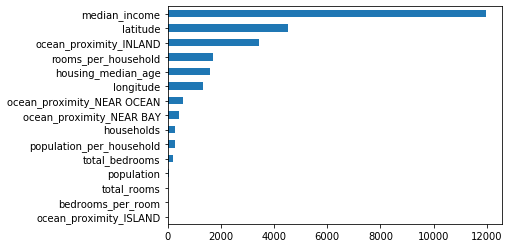

In [64]:
pd.Series(abs(grid.best_estimator_.named_steps["svr"].coef_[0])
,index = housing_prepared.columns).sort_values(ascending=True).plot(kind='barh')